In [45]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json
import yaml
import ast
from pathlib import Path
from functools import partial
from tqdm.notebook import tqdm
from IPython.display import Audio
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram
import librosa
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset

class Vicente(Dataset):
    def __init__(self, categories):
        self.file_paths = []
        self.meta = pd.read_csv('../../datasets/Vicente/Metadata.csv', 
                                encoding='latin-1', sep=';', header=0, comment='#', parse_dates=[4])
        self.labels = []
        self.folder = []
        for file in Path('../../datasets/Vicente/').rglob('*.wav'):
            tag = self.match_ids(file)["Tag 1"].apply(lambda x: x.split(':')[0] if isinstance(x, str) else None)
            if len(tag) == 0:
                #print(id, file, tag)
                continue
            self.labels.append(tag.item().lower())
            #self.labels.append(tag.item())
            self.file_paths.append(file)
            self.folder.append(file.parent.stem)
        self.categories = categories
    
    def match_ids(self, file_name):
        id = file_name.stem
        if id[-3:] == '(1)':
            id = id[:-3]
        return self.meta.loc[self.meta['Id'] == id]         
        
    def __getitem__(self, idx):
        #return self.file_paths[idx], 'dog'
        return self.file_paths[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.file_paths)
    
dataset = Vicente(categories=vicente_df.columns)
dataset[0]

(PosixPath('../../datasets/Vicente/Ubicación 2 Semana 1/1655619957_1655620017.wav'),
 'humans/others')

In [ ]:
filename start end label station labeller
1655826106_1655826166.wav 0.0 60.019998677571614 truck_idling capta Esteban_G

In [ ]:
Id;Tag 1;Tag 2;Tag 3;Fecha y hora
1653306233_1653306293;humans/others:0.507;animal/bird:0.33;Music/music:0.047;2022-05-23 11:36:53

In [49]:
import pickle

#with open('UrbanSound_ESC-PANN-tag.pkl', 'rb') as f:
with open('UrbanSound_ESC-PANN-tag-pink-noise-pretrained.pkl', 'rb') as f:
    vicente_results = pickle.load(f)

th = 0.5
summarized_result = []
for name, percentages in vicente_results.items():
    summarized_result.append((percentages > th).sum()/12)
print(len(summarized_result))


vicente_df = pd.DataFrame(summarized_result, index=list(vicente_results.keys()))
idx_duplicates = [idx for idx, repeated in (vicente_df.index.map(lambda x: ''.join(x.split('(1)'))).value_counts() > 1).items() if repeated]
vicente_df_noduplo = vicente_df.drop(idx_duplicates)
#display(vicente_df.head())
vicente_df_noduplo.describe().T

117


count      mean       std  min  25%  50%  \
alerts/bells                115.0  0.000000  0.000000  0.0  0.0  0.0   
alerts/horns                115.0  0.000000  0.000000  0.0  0.0  0.0   
alerts/siren                115.0  0.079710  0.141521  0.0  0.0  0.0   
animal/bird                 115.0  0.000725  0.007771  0.0  0.0  0.0   
animal/dog                  115.0  0.096377  0.258291  0.0  0.0  0.0   
animal/others               115.0  0.000725  0.007771  0.0  0.0  0.0   
environmental/others        115.0  0.003623  0.025629  0.0  0.0  0.0   
environmental/rain          115.0  0.247826  0.358763  0.0  0.0  0.0   
environmental/waves         115.0  0.000000  0.000000  0.0  0.0  0.0   
environmental/wind          115.0  0.000000  0.000000  0.0  0.0  0.0   
humans/others               115.0  0.007246  0.026039  0.0  0.0  0.0   
mechanical/air_conditioner  115.0  0.003623  0.017069  0.0  0.0  0.0   
mechanical/cutting          115.0  0.000000  0.000000  0.0  0.0  0.0   
mechanical/digging          115.0  0.007971  0.085480  0.0  0.0  0.0   
mechanical/explosives       115.0  0.016667  0.069983  0.0  0.0  0.0   
mechanical/impact           115.0  0.002174  0.017315  0.0  0.0  0.0   
mechanical/others           115.0  0.073913  0.180617  0.0  0.0  0.0   
music/music                 115.0  0.005797  0.026403  0.0  0.0  0.0   
vehicles/airborne           115.0  0.001449  0.015542  0.0  0.0  0.0   
vehicles/others             115.0  0.000000  0.000000  0.0  0.0  0.0   

                                 75%       max  
alerts/bells                0.000000  0.000000  
alerts/horns                0.000000  0.000000  
alerts/siren                0.166667  0.750000  
animal/bird                 0.000000  0.083333  
animal/dog                  0.000000  1.000000  
animal/others               0.000000  0.083333  
environmental/others        0.000000  0.250000  
environmental/rain          0.458333  1.000000  
environmental/waves         0.000000  0.000000  
environmental/wind          0.000000  0.000000  
humans/others               0.000000  0.166667  
mechanical/air_conditioner  0.000000  0.083333  
mechanical/cutting          0.000000  0.000000  
mechanical/digging          0.000000  0.916667  
mechanical/explosives       0.000000  0.416667  
mechanical/impact           0.000000  0.166667  
mechanical/others           0.000000  0.916667  
music/music                 0.000000  0.166667  
vehicles/airborne           0.000000  0.166667  
vehicles/others             0.000000  0.000000

In [50]:
mask_rows = (vicente_df_noduplo.T > 0.75).any()
mask_cols = (vicente_df_noduplo > 0.75).any()
strong_ocurrence = vicente_df_noduplo.loc[mask_rows, mask_cols]

In [51]:
mask_offensive_class = strong_ocurrence.idxmax(axis=1) == 'mechanical/digging'
display(strong_ocurrence.loc[mask_offensive_class])
mask_offensive_class = strong_ocurrence.idxmax(axis=1) == 'mechanical/air_conditioner'
display(strong_ocurrence.loc[mask_offensive_class])
mask_offensive_class = strong_ocurrence.idxmax(axis=1) == 'mechanical/others'
display(strong_ocurrence.loc[mask_offensive_class])

animal/dog  environmental/rain  mechanical/digging  \
1653409372_1653409432.wav         0.0                 0.0            0.916667   

                           mechanical/others  
1653409372_1653409432.wav                0.0

Empty DataFrame
Columns: [animal/dog, environmental/rain, mechanical/digging, mechanical/others]
Index: []

animal/dog  environmental/rain  \
1655826106_1655826166.wav            0.0                 0.0   
1654224726_1654224786(1).wav         0.0                 0.0   

                              mechanical/digging  mechanical/others  
1655826106_1655826166.wav                    0.0           0.916667  
1654224726_1654224786(1).wav                 0.0           0.833333

In [17]:
vicente_df.columns, len(vicente_df.columns)

(Index(['alerts/bells', 'alerts/horns', 'alerts/siren', 'animal/bird',
        'animal/dog', 'animal/others', 'environmental/others',
        'environmental/rain', 'environmental/waves', 'environmental/wind',
        'humans/others', 'mechanical/air_conditioner', 'mechanical/cutting',
        'mechanical/digging', 'mechanical/explosives', 'mechanical/impact',
        'mechanical/others', 'music/music', 'vehicles/airborne',
        'vehicles/others'],
       dtype='object'),
 20)

In [29]:
dataset[0]

(PosixPath('../../datasets/Vicente/Ubicación 2 Semana 1/1655619957_1655620017.wav'),
 'humans/others')

0      1653306233_1653306293
1      1653323280_1653323340
2      1653357451_1653357511
3      1653360419_1653360479
4      1653361511_1653361571
               ...          
111    1655621595_1655621655
112    1655621898_1655621958
113    1655653356_1655653416
114    1655826045_1655826105
115    1655826106_1655826166
Name: Id, Length: 116, dtype: object
0      1653306233_1653306293
1      1653323280_1653323340
2      1653357451_1653357511
3      1653360419_1653360479
4      1653361511_1653361571
               ...          
111    1655621595_1655621655
112    1655621898_1655621958
113    1655653356_1655653416
114    1655826045_1655826105
115    1655826106_1655826166
Name: Id, Length: 116, dtype: object
0      1653306233_1653306293
1      1653323280_1653323340
2      1653357451_1653357511
3      1653360419_1653360479
4      1653361511_1653361571
               ...          
111    1655621595_1655621655
112    1655621898_1655621958
113    1655653356_1655653416
114    1655826045_165582610

Id                             Tag 1  \
11  1653446828_1653446888  mechanical/air_conditioner:0.287   

                Tag 2               Tag 3        Fecha y hora  
11  Music/music:0.277  humans/others:0.08 2022-05-25 02:47:08

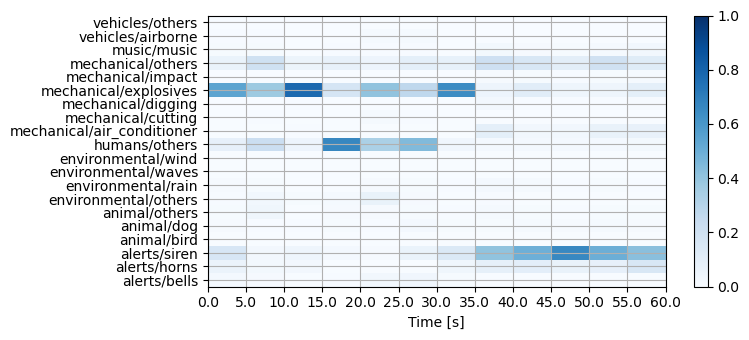

In [44]:
dataset = Vicente(categories=vicente_df.columns)
path, _ = dataset[vicente_df.index.get_loc('1655826106_1655826166.wav')] # mechanical-other
#path, _ = dataset[vicente_df.index.get_loc('1653409372_1653409432.wav')] # digging/cutting
#path, _ = dataset[vicente_df.index.get_loc('1654224726_1654224786(1).wav')]
#path, _ = dataset[vicente_df.index.get_loc('1654286174_1654286234(1).wav')] #dog
#path, _ = dataset[102]

meta = dataset.match_ids(path)
display(meta)

#window_size = 32000*5
#preds = []
#with torch.no_grad():
#    for i in range(sample['waveform'].shape[-1]//window_size):
#        preds_ = torch.nn.Softmax(dim=-1)(model({'waveform': sample['waveform'][:, i*window_size:(i+1)*window_size].unsqueeze(0)})).detach()
#        preds.append(preds_.numpy())
#preds = np.stack(preds)[:, 0, :]
preds = vicente_results[path.name]
fig, ax = plt.subplots(figsize=(8, 3.5), tight_layout=True)
img = ax.pcolormesh(preds.T, vmin=0, vmax=1, cmap=plt.cm.Blues)
plt.colorbar(img)
ax.set_xticks(np.arange(preds.shape[0]+1))
ax.set_xticklabels(np.linspace(0, 60, num=preds.shape[0]+1))
ax.set_yticks(np.arange(len(vicente_df.columns))+0.5)
ax.set_yticklabels(vicente_df.columns);
ax.set_xlabel('Time [s]')
ax.grid()
#plt.savefig('non-compliant3.pdf')

waveform, rate = torchaudio.load(path)
Audio(data=waveform[0].numpy(), rate=rate)